In [306]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import OneHotEncoder,StandardScaler
from sklearn.model_selection import train_test_split
import os
import joblib

### Initial Data Inspection

In [307]:
df=pd.read_csv('Data_Sets\SuperMarket Analysis.csv')

In [308]:
df.head()

,Invoice ID,Branch,City,Customer type,Gender,Product line,Unit price,Quantity,Tax 5%,Sales,Date,Time,Payment,cogs,gross margin percentage,gross income,Rating
0,750-67-8428,Alex,Yangon,Member,Female,Health and beauty,74.69,7,26.1415,548.9715,1/5/2019,1:08:00 PM,Ewallet,522.83,4.761905,26.1415,9.1
1,226-31-3081,Giza,Naypyitaw,Normal,Female,Electronic accessories,15.28,5,3.8200,80.2200,3/8/2019,10:29:00 AM,Cash,76.40,4.761905,3.8200,9.6
2,631-41-3108,Alex,Yangon,Normal,Female,Home and lifestyle,46.33,7,16.2155,340.5255,3/3/2019,1:23:00 PM,Credit card,324.31,4.761905,16.2155,7.4
3,123-19-1176,Alex,Yangon,Member,Female,Health and beauty,58.22,8,23.2880,489.0480,1/27/2019,8:33:00 PM,Ewallet,465.76,4.761905,23.2880,8.4
4,373-73-7910,Alex,Yangon,Member,Female,Sports and travel,86.31,7,30.2085,634.3785,2/8/2019,10:37:00 AM,Ewallet,604.17,4.761905,30.2085,5.3


In [309]:
pd.set_option('display.max_columns', None)

In [310]:
df.duplicated().sum()

np.int64(0)

In [311]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 17 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Invoice ID               1000 non-null   object 
 1   Branch                   1000 non-null   object 
 2   City                     1000 non-null   object 
 3   Customer type            1000 non-null   object 
 4   Gender                   1000 non-null   object 
 5   Product line             1000 non-null   object 
 6   Unit price               1000 non-null   float64
 7   Quantity                 1000 non-null   int64  
 8   Tax 5%                   1000 non-null   float64
 9   Sales                    1000 non-null   float64
 10  Date                     1000 non-null   object 
 11  Time                     1000 non-null   object 
 12  Payment                  1000 non-null   object 
 13  cogs                     1000 non-null   float64
 14  gross margin percentage  

### Feature Engineering on Date/Time Columns

In [312]:
df['Date']=pd.to_datetime(df['Date'])
df['Time'] = pd.to_datetime(df['Time'], format='%I:%M:%S %p').dt.time


In [313]:
df['Date'].head()

0   2019-01-05
1   2019-03-08
2   2019-03-03
3   2019-01-27
4   2019-02-08
Name: Date, dtype: datetime64[ns]

In [314]:
df['Time'].head()

0    13:08:00
1    10:29:00
2    13:23:00
3    20:33:00
4    10:37:00
Name: Time, dtype: object

In [315]:
df.describe()

,Unit price,Quantity,Tax 5%,Sales,Date,cogs,gross margin percentage,gross income,Rating
count,1000.000000,1000.000000,1000.000000,1000.000000,1000,1000.00000,1000.000000,1000.000000,1000.00000
mean,55.672130,5.510000,15.379369,322.966749,2019-02-14 00:05:45.600000,307.58738,4.761905,15.379369,6.97270
min,10.080000,1.000000,0.508500,10.678500,2019-01-01 00:00:00,10.17000,4.761905,0.508500,4.00000
25%,32.875000,3.000000,5.924875,124.422375,2019-01-24 00:00:00,118.49750,4.761905,5.924875,5.50000
50%,55.230000,5.000000,12.088000,253.848000,2019-02-13 00:00:00,241.76000,4.761905,12.088000,7.00000
75%,77.935000,8.000000,22.445250,471.350250,2019-03-08 00:00:00,448.90500,4.761905,22.445250,8.50000
max,99.960000,10.000000,49.650000,1042.650000,2019-03-30 00:00:00,993.00000,4.761905,49.650000,10.00000
std,26.494628,2.923431,11.708825,245.885335,NaN,234.17651,0.000000,11.708825,1.71858


In [316]:
# ML Models cannot use raw date and time data directly do we convert them into numerical columns

In [317]:
df.head()

,Invoice ID,Branch,City,Customer type,Gender,Product line,Unit price,Quantity,Tax 5%,Sales,Date,Time,Payment,cogs,gross margin percentage,gross income,Rating
0,750-67-8428,Alex,Yangon,Member,Female,Health and beauty,74.69,7,26.1415,548.9715,2019-01-05,13:08:00,Ewallet,522.83,4.761905,26.1415,9.1
1,226-31-3081,Giza,Naypyitaw,Normal,Female,Electronic accessories,15.28,5,3.8200,80.2200,2019-03-08,10:29:00,Cash,76.40,4.761905,3.8200,9.6
2,631-41-3108,Alex,Yangon,Normal,Female,Home and lifestyle,46.33,7,16.2155,340.5255,2019-03-03,13:23:00,Credit card,324.31,4.761905,16.2155,7.4
3,123-19-1176,Alex,Yangon,Member,Female,Health and beauty,58.22,8,23.2880,489.0480,2019-01-27,20:33:00,Ewallet,465.76,4.761905,23.2880,8.4
4,373-73-7910,Alex,Yangon,Member,Female,Sports and travel,86.31,7,30.2085,634.3785,2019-02-08,10:37:00,Ewallet,604.17,4.761905,30.2085,5.3


In [318]:
# We can also map the values if necassary

In [319]:
df['DayOfWeek'] = df['Date'].dt.dayofweek


In [320]:
df['Day'] = df['Date'].dt.day


In [321]:
df['Month'] = df['Date'].dt.month


In [322]:
#  Fot Time

In [323]:
# df['Hour'] = pd.to_datetime(df['Time'], format='%H:%M:%S').dt.hour
df['Hour'] = df['Time'].apply(lambda x: x.hour)


In [324]:
df['TimeOfDay'] = df['Hour'].apply(
    lambda h: 'Morning' if 5 <= h < 12 else
              'Afternoon' if 12 <= h < 17 else
              'Evening' if 17 <= h < 21 else
              'Night'
)


In [325]:
df.head()

,Invoice ID,Branch,City,Customer type,Gender,Product line,Unit price,Quantity,Tax 5%,Sales,Date,Time,Payment,cogs,gross margin percentage,gross income,Rating,DayOfWeek,Day,Month,Hour,TimeOfDay
0,750-67-8428,Alex,Yangon,Member,Female,Health and beauty,74.69,7,26.1415,548.9715,2019-01-05,13:08:00,Ewallet,522.83,4.761905,26.1415,9.1,5,5,1,13,Afternoon
1,226-31-3081,Giza,Naypyitaw,Normal,Female,Electronic accessories,15.28,5,3.8200,80.2200,2019-03-08,10:29:00,Cash,76.40,4.761905,3.8200,9.6,4,8,3,10,Morning
2,631-41-3108,Alex,Yangon,Normal,Female,Home and lifestyle,46.33,7,16.2155,340.5255,2019-03-03,13:23:00,Credit card,324.31,4.761905,16.2155,7.4,6,3,3,13,Afternoon
3,123-19-1176,Alex,Yangon,Member,Female,Health and beauty,58.22,8,23.2880,489.0480,2019-01-27,20:33:00,Ewallet,465.76,4.761905,23.2880,8.4,6,27,1,20,Evening
4,373-73-7910,Alex,Yangon,Member,Female,Sports and travel,86.31,7,30.2085,634.3785,2019-02-08,10:37:00,Ewallet,604.17,4.761905,30.2085,5.3,4,8,2,10,Morning


In [326]:
df.drop(columns=['Date','Time'],inplace=True)

In [327]:
df.drop(columns=['Invoice ID'],inplace=True)

## EDA

##### Univariate Analysis

In [328]:
num_cols=df.select_dtypes(include=['number','int','float'])
cat_cols=df.select_dtypes(exclude=['number','int','float'])

In [329]:
num_cols.columns

Index(['Unit price', 'Quantity', 'Tax 5%', 'Sales', 'cogs',
       'gross margin percentage', 'gross income', 'Rating', 'DayOfWeek', 'Day',
       'Month', 'Hour'],
      dtype='object')

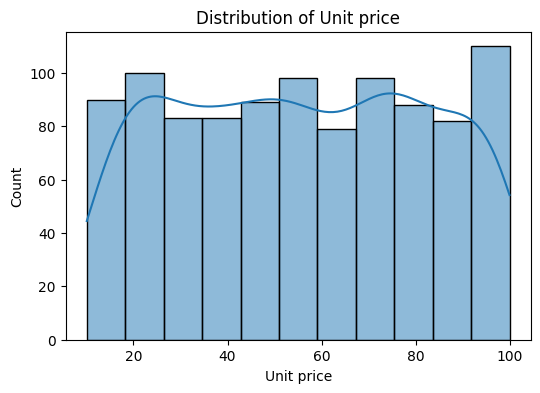

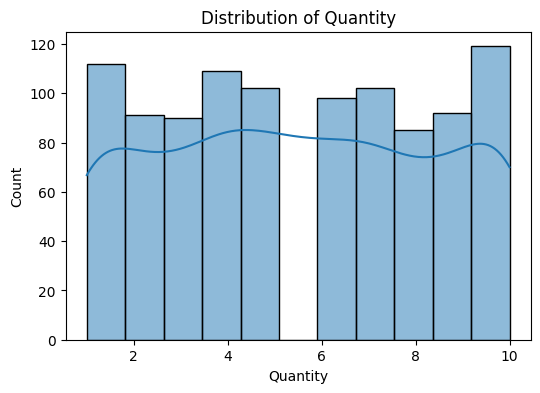

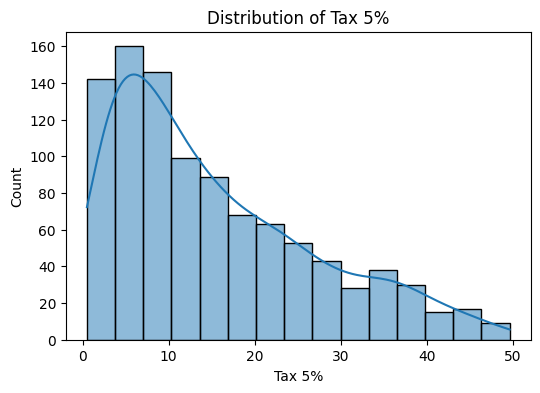

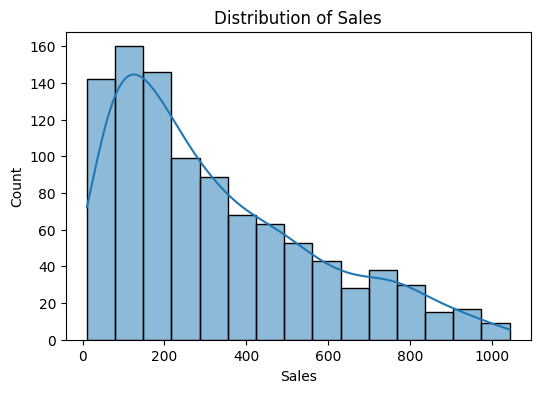

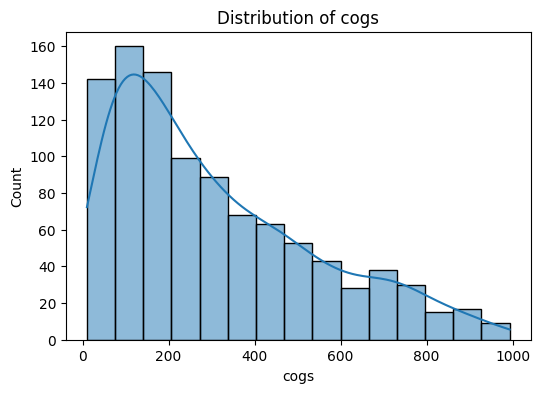

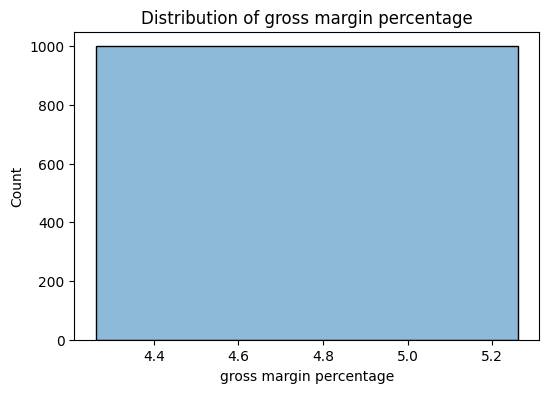

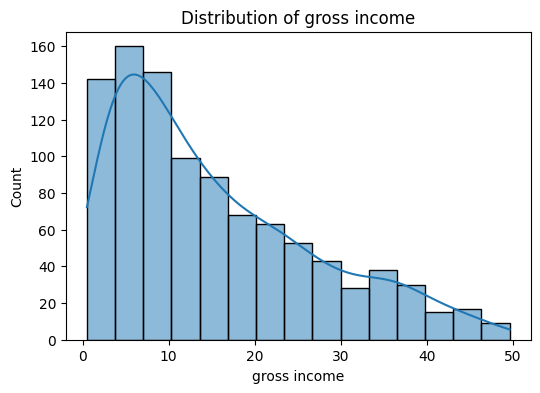

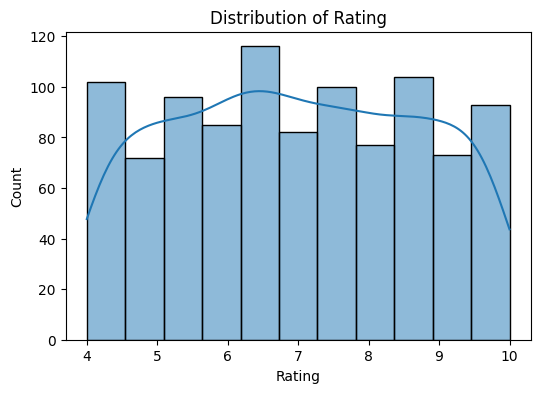

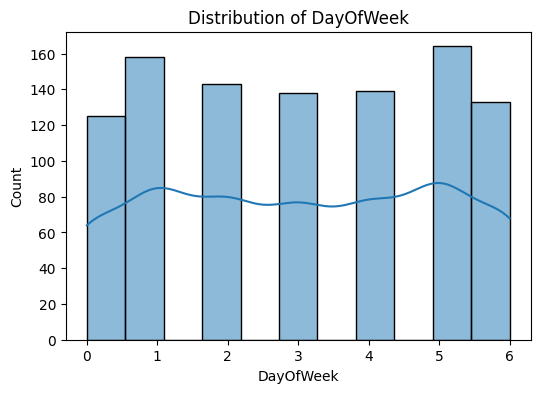

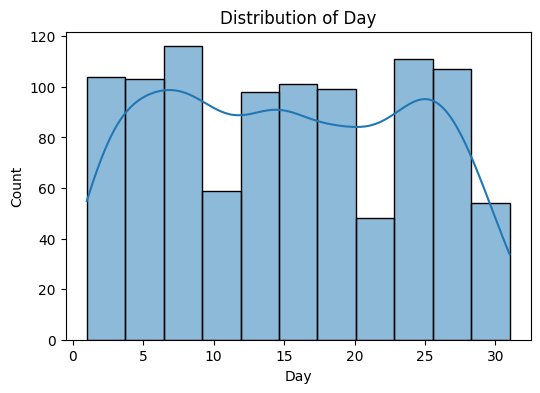

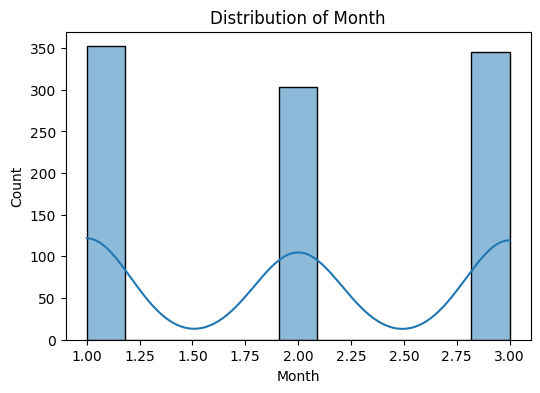

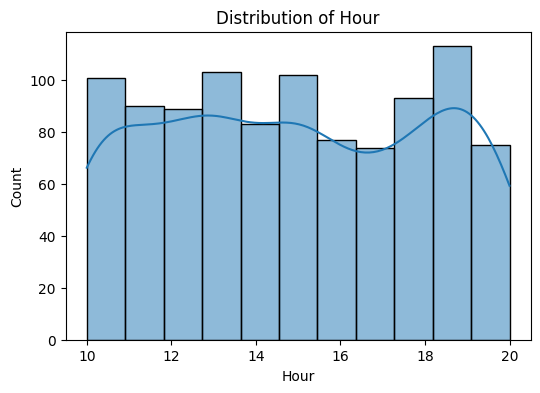

In [330]:
for col in num_cols:
    plt.figure(figsize=(6,4))
    sns.histplot(df[col], kde=True)
    plt.title(f'Distribution of {col}')
    plt.show()

In [331]:
from scipy.stats import skew
print("Skewness:", skew(num_cols['Sales']))

Skewness: 0.8912303920037631


In [332]:
# Skewness 0.8912303920037631 means that the target column is right skewed, hence we use log transformation to make it normal

In [333]:
# Will do this after initail model trianing IF NECESSARY
# df['Sales_transformed'] = np.log1p(num_cols['Sales'])

In [334]:
# from scipy.stats import skew
# print(skew(train_cleaned['Sales_transformed']))

In [335]:
# using powertransformer to handle skeweness

In [336]:
#Skip for now
# from sklearn.preprocessing import PowerTransformer

# pt = PowerTransformer(method='yeo-johnson')
# train_cleaned['Sales_transformed'] = pt.fit_transform(num_cols[['Sales']])


In [337]:
# plt.figure(figsize=(5,6))
# sns.histplot(train_cleaned['Sales_transformed'], kde=True)
# plt.title(f'Distribution of {col}')
# plt.show()

In [338]:
num_cols=df.select_dtypes(include=['int','float','number'])

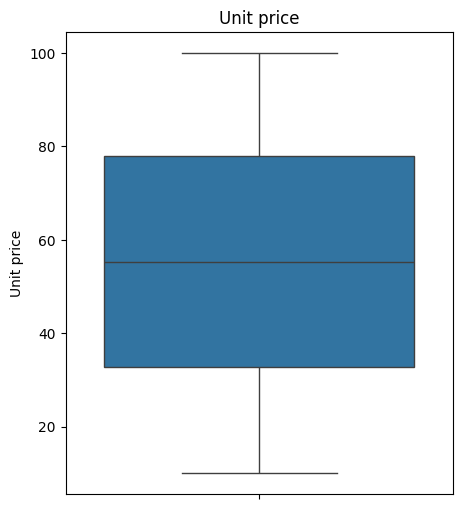

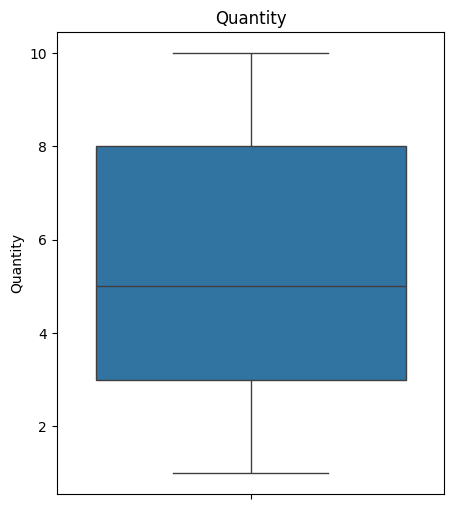

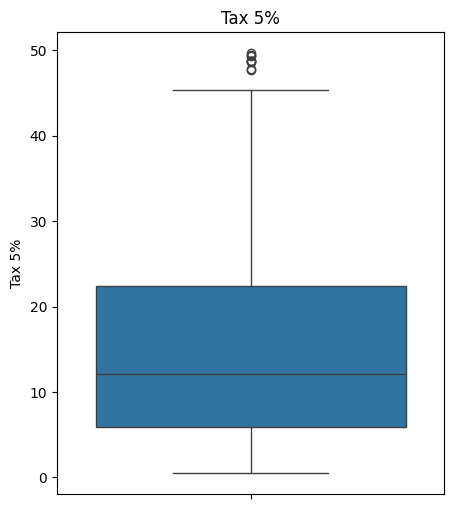

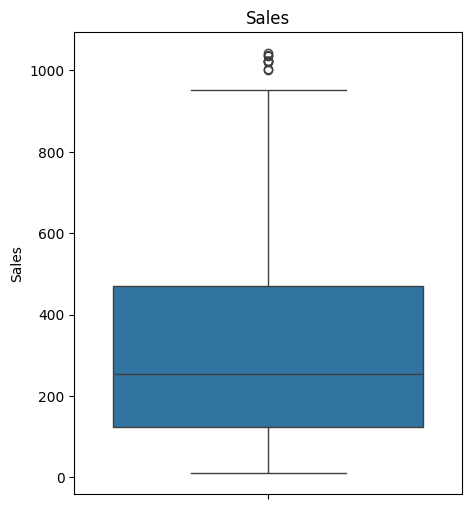

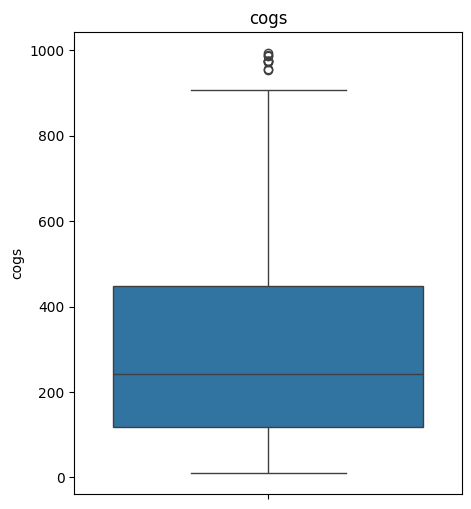

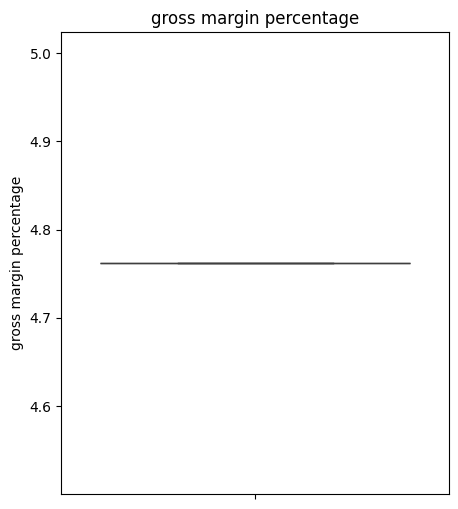

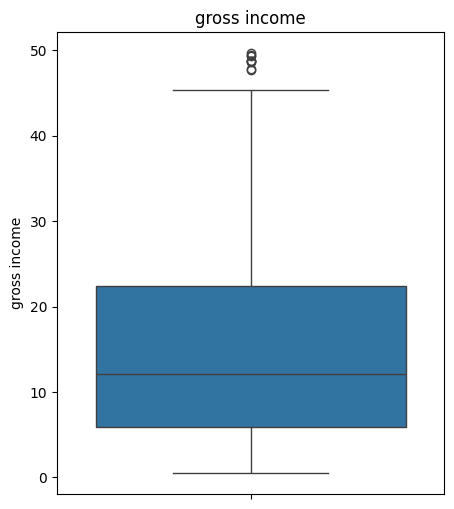

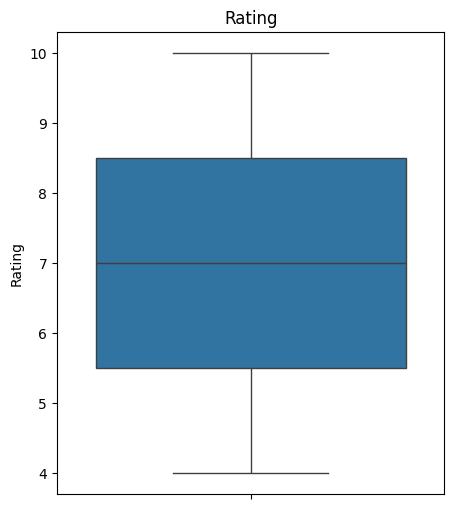

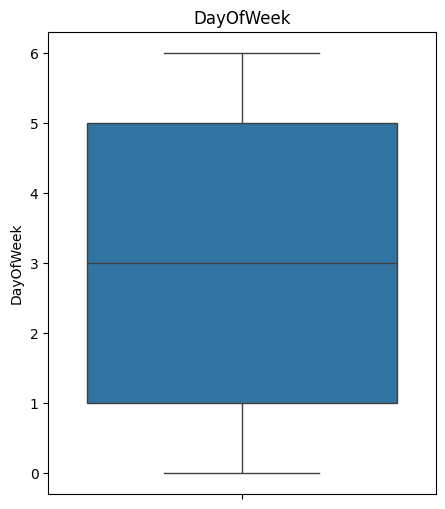

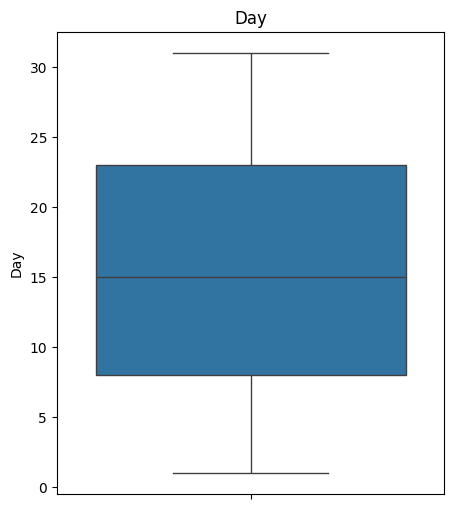

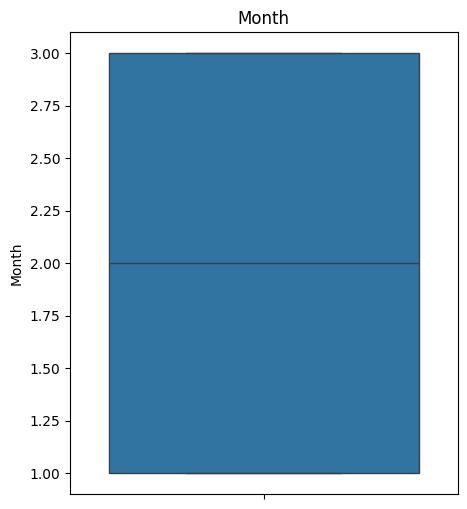

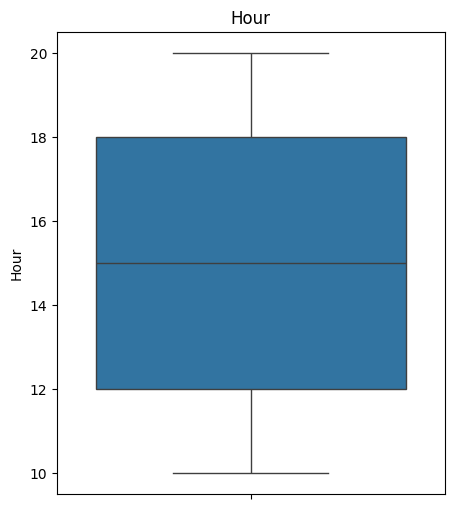

In [339]:
for col in num_cols:
    plt.figure(figsize=(5,6))
    sns.boxplot(num_cols[col])
    plt.title(col)
    plt.show()

In [340]:
# We can see that there are outliers present in the target column

In [341]:
# import numpy as np

# Q1 = num_cols['Sales_transformed'].quantile(0.25)
# Q3 = num_cols['Sales_transformed'].quantile(0.75)
# IQR = Q3 - Q1

# lower_bound = Q1 - 1.5 * IQR
# upper_bound = Q3 + 1.5 * IQR

# outliers = num_cols[(num_cols['Sales_transformed'] < lower_bound) | (num_cols['Sales_transformed'] > upper_bound)]
# print(f"Outlier count: {len(outliers)} ({len(outliers)/len(num_cols)*100:.2f}% of data)")


In [342]:
# To deal with outlier we use Winsorization

# Winsorization is a statistical technique used to limit the influence of extreme values (outliers)
#  by capping them at specific percentile thresholds — rather than removing them.
# It brings extreme values closer to the bulk of the data, instead of deleting them.


In [343]:
#Skip for now
# from scipy.stats.mstats import winsorize
# train_cleaned['Sales_transformed_capped']=winsorize(train_cleaned['Sales_transformed'],limits=[0.01,0.01])


In [344]:
cat_cols.head()

,Branch,City,Customer type,Gender,Product line,Payment,TimeOfDay
0,Alex,Yangon,Member,Female,Health and beauty,Ewallet,Afternoon
1,Giza,Naypyitaw,Normal,Female,Electronic accessories,Cash,Morning
2,Alex,Yangon,Normal,Female,Home and lifestyle,Credit card,Afternoon
3,Alex,Yangon,Member,Female,Health and beauty,Ewallet,Evening
4,Alex,Yangon,Member,Female,Sports and travel,Ewallet,Morning


In [345]:
for col in cat_cols:
    vc = df[col].value_counts() # counts how many times each unique category appears in that column.
    pct = df[col].value_counts(normalize=True).mul(100)#finds what percentage of total data each represents.
    summary = pd.concat([vc, pct], axis=1)# axis=1 means to concatenate horizontally
    summary.columns = ['count','percent']
    print(f"\n=== {col} ===")
    print(summary)



=== Branch ===
        count  percent
Branch                
Alex      340     34.0
Cairo     332     33.2
Giza      328     32.8

=== City ===
           count  percent
City                     
Yangon       340     34.0
Mandalay     332     33.2
Naypyitaw    328     32.8

=== Customer type ===
               count  percent
Customer type                
Member           565     56.5
Normal           435     43.5

=== Gender ===
        count  percent
Gender                
Female    571     57.1
Male      429     42.9

=== Product line ===
                        count  percent
Product line                          
Fashion accessories       178     17.8
Food and beverages        174     17.4
Electronic accessories    170     17.0
Sports and travel         166     16.6
Home and lifestyle        160     16.0
Health and beauty         152     15.2

=== Payment ===
             count  percent
Payment                    
Ewallet        345     34.5
Cash           344     34.4
Credit card

In [346]:
cat_cols.head()

,Branch,City,Customer type,Gender,Product line,Payment,TimeOfDay
0,Alex,Yangon,Member,Female,Health and beauty,Ewallet,Afternoon
1,Giza,Naypyitaw,Normal,Female,Electronic accessories,Cash,Morning
2,Alex,Yangon,Normal,Female,Home and lifestyle,Credit card,Afternoon
3,Alex,Yangon,Member,Female,Health and beauty,Ewallet,Evening
4,Alex,Yangon,Member,Female,Sports and travel,Ewallet,Morning


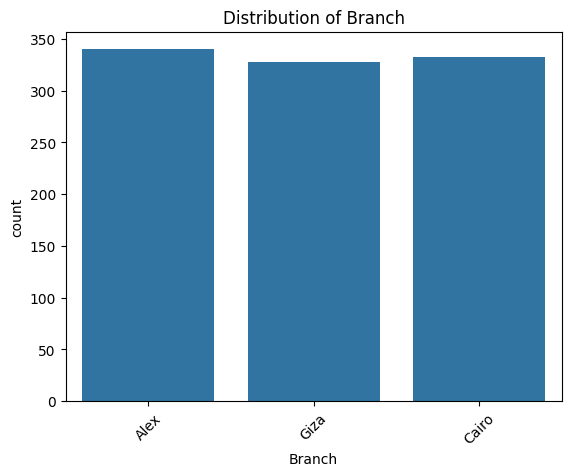

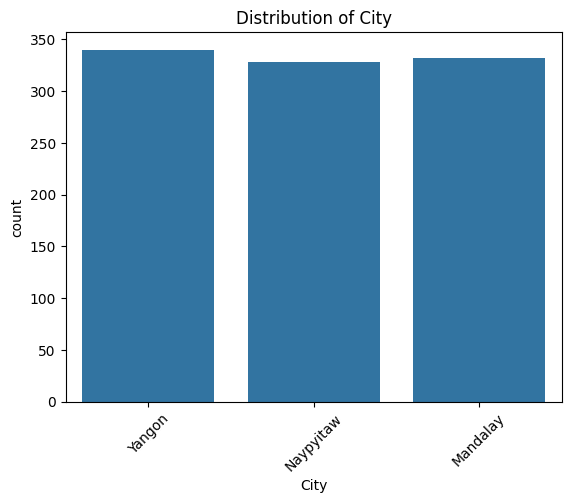

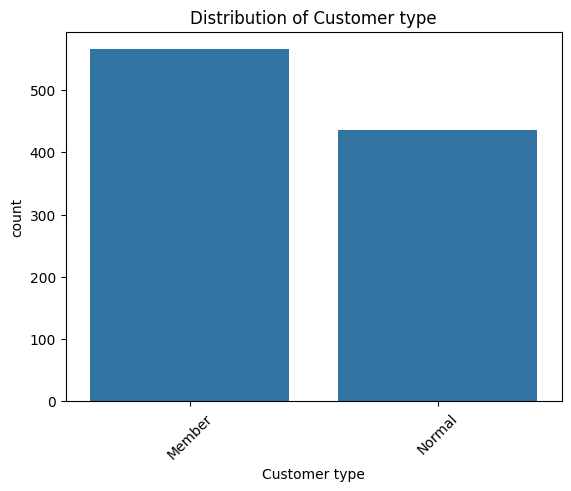

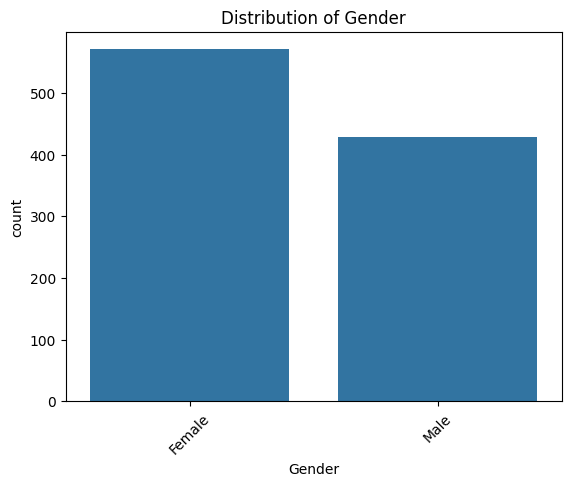

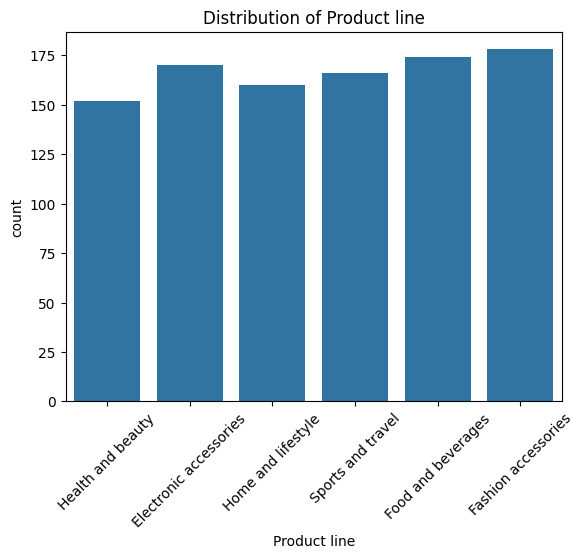

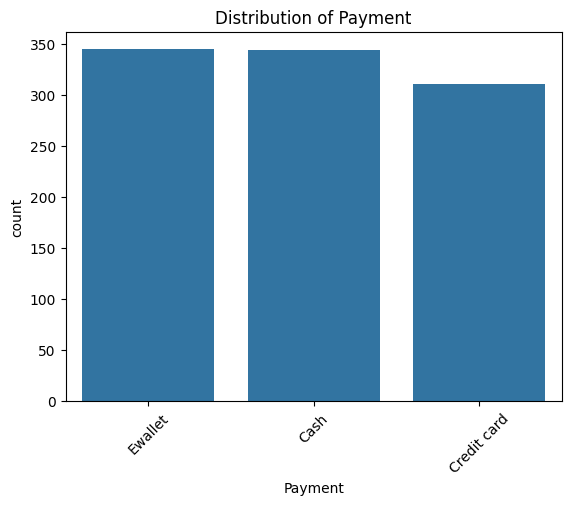

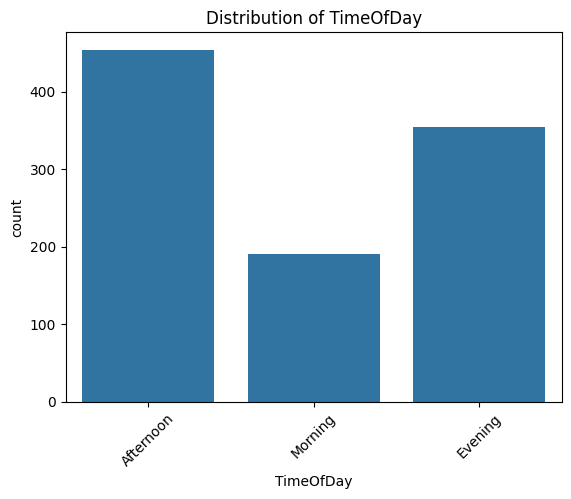

In [347]:

for col in cat_cols:
    sns.countplot(data=df,x=col)
    plt.title(f'Distribution of {col}')
    plt.xticks(rotation=45)
    plt.show()

-Bivariate Data

In [348]:
num_cols.head()

,Unit price,Quantity,Tax 5%,Sales,cogs,gross margin percentage,gross income,Rating,DayOfWeek,Day,Month,Hour
0,74.69,7,26.1415,548.9715,522.83,4.761905,26.1415,9.1,5,5,1,13
1,15.28,5,3.8200,80.2200,76.40,4.761905,3.8200,9.6,4,8,3,10
2,46.33,7,16.2155,340.5255,324.31,4.761905,16.2155,7.4,6,3,3,13
3,58.22,8,23.2880,489.0480,465.76,4.761905,23.2880,8.4,6,27,1,20
4,86.31,7,30.2085,634.3785,604.17,4.761905,30.2085,5.3,4,8,2,10


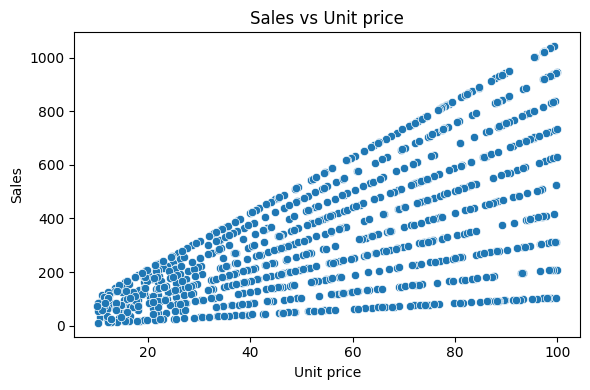

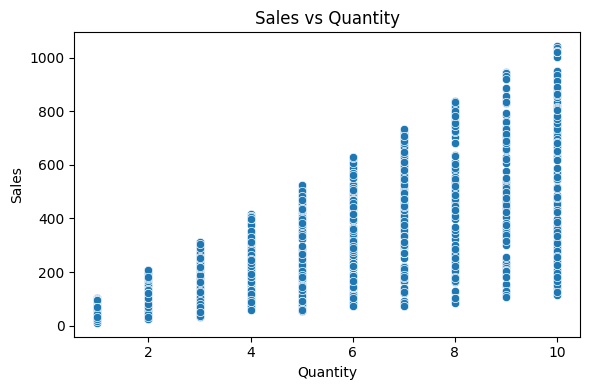

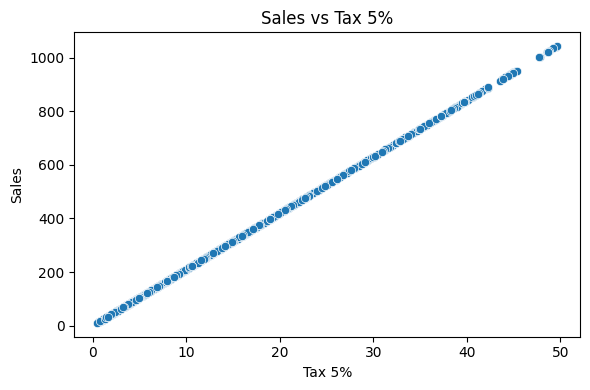

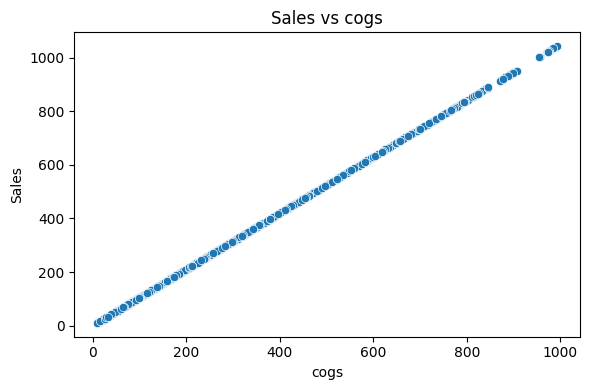

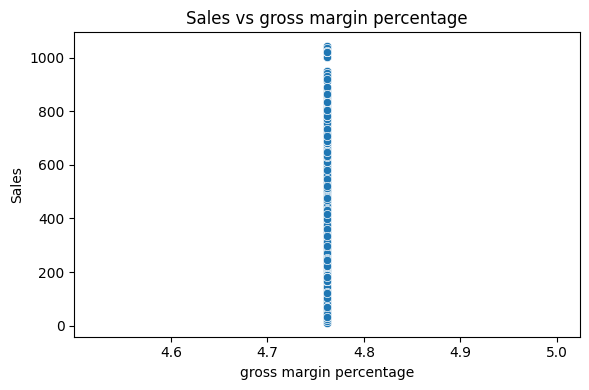

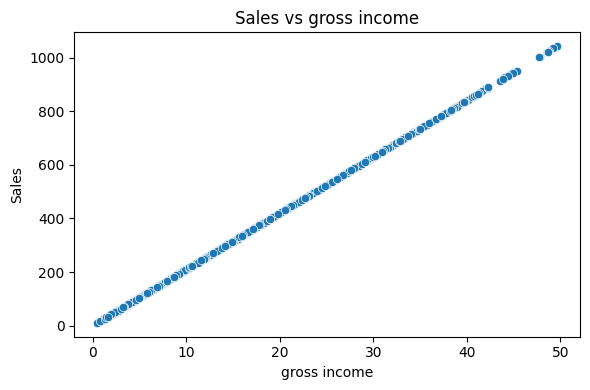

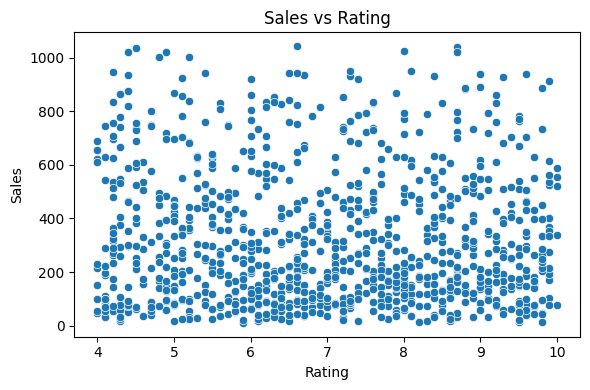

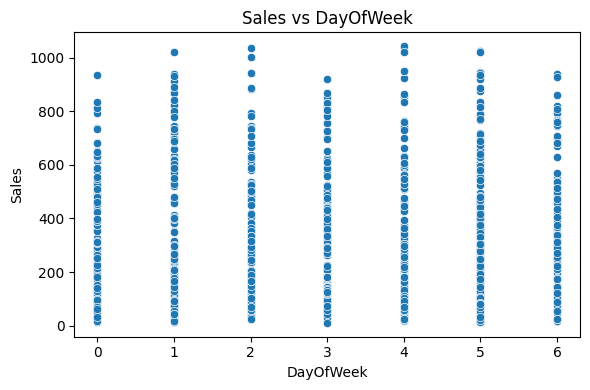

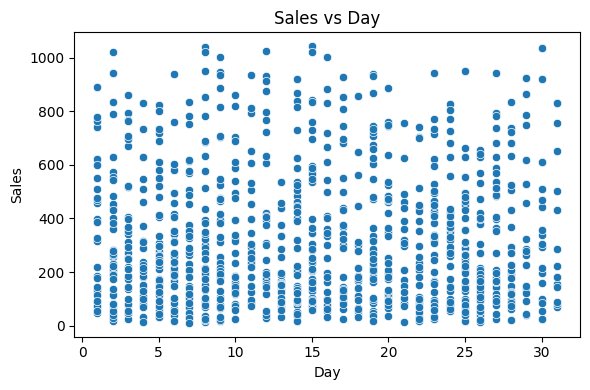

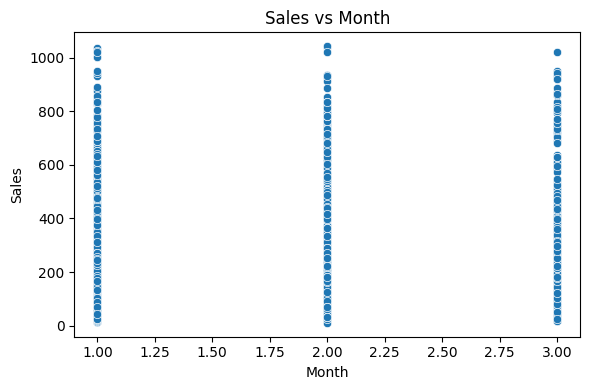

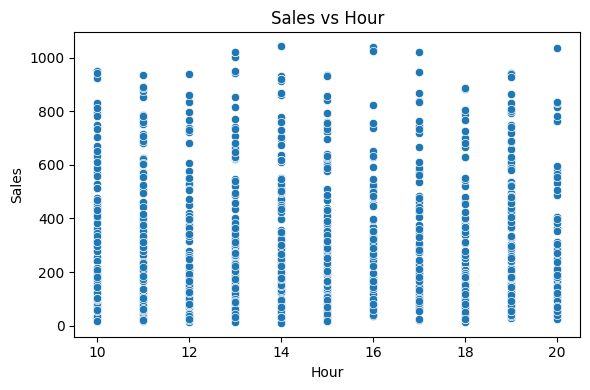


Correlation with Sales:

Sales                      1.000000
gross income               1.000000
Tax 5%                     1.000000
cogs                       1.000000
Quantity                   0.705510
Unit price                 0.633962
DayOfWeek                  0.038809
Day                       -0.002515
Hour                      -0.002770
Month                     -0.022301
Rating                    -0.036442
gross margin percentage         NaN
Name: Sales, dtype: float64


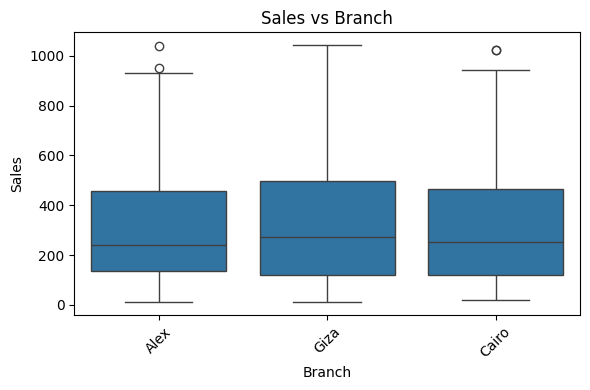

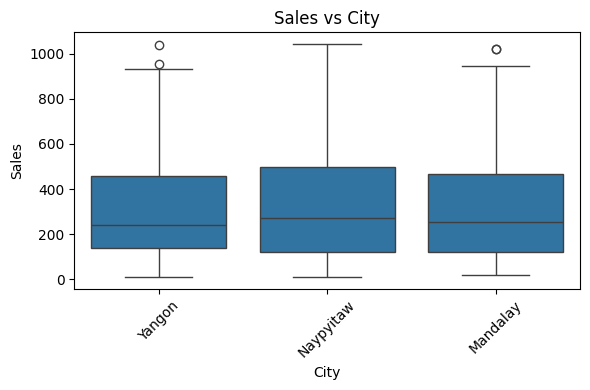

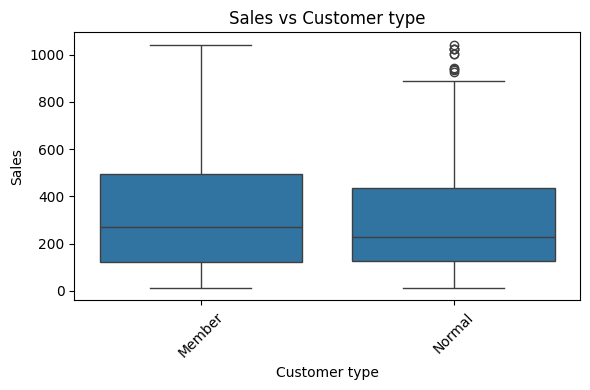

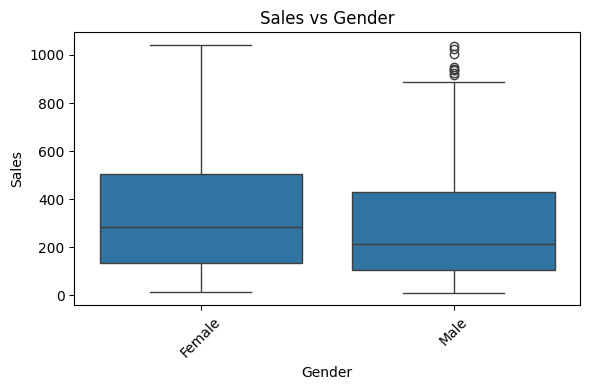

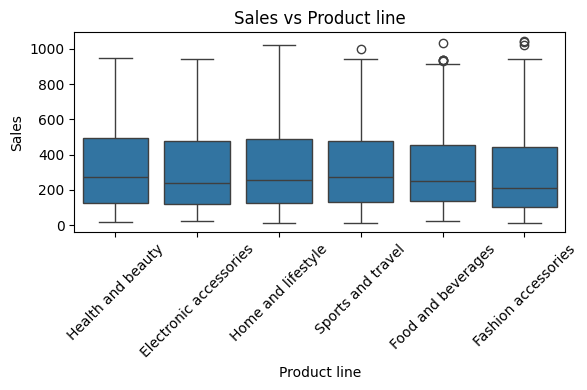

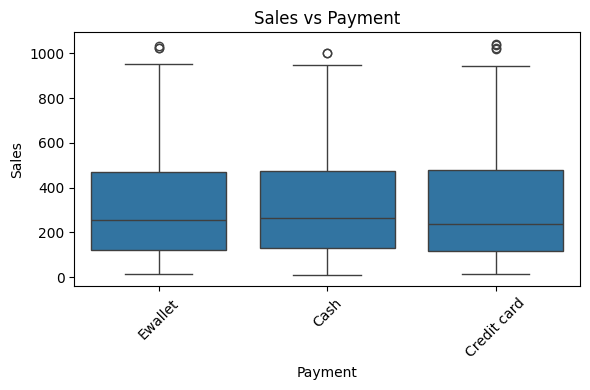

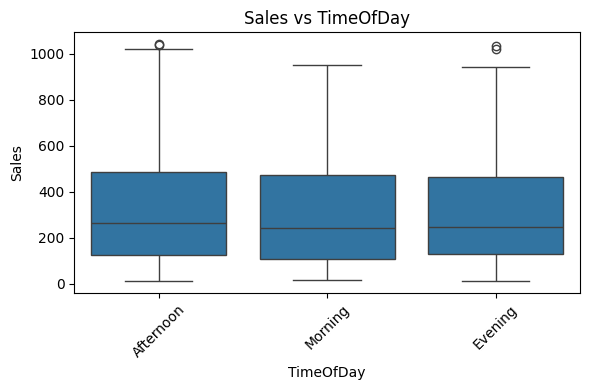

In [349]:

# ================================
# Numerical vs Sales
# ================================
num_cols = df.select_dtypes(include=['number', 'float', 'int']).columns

for col in num_cols:
    if col != 'Sales':     # skip Sales vs Sales
        plt.figure(figsize=(6,4))
        sns.scatterplot(x=df[col], y=df['Sales'])
        plt.title(f"Sales vs {col}")
        plt.tight_layout()
        plt.show()

# Correlation of Sales with other numeric columns
corr_with_sales = df[num_cols].corr()['Sales'].sort_values(ascending=False)
print("\nCorrelation with Sales:\n")
print(corr_with_sales)


# ================================
# Categorical vs Sales
# ================================
cat_cols = df.select_dtypes(exclude=['number', 'float', 'int']).columns

for col in cat_cols:
    plt.figure(figsize=(6,4))
    sns.boxplot(x=df[col], y=df['Sales'])
    plt.title(f"Sales vs {col}")
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()


Regression Line


In [350]:
# import pandas as pd
# import seaborn as sns
# import matplotlib.pyplot as plt

# # Assume train_processed has been preprocessed
# numeric_cols = df.select_dtypes(include=['float64','int64']).columns

# # Compute correlation matrix
# corr_matrix = df[numeric_cols].corr()

# #Regression line plot
# sns.lmplot(x='Item_MRP', y='Sales_transformed_capped', data=df, height=6)
# plt.title("Linear Regression Line: MRP vs Sales")
# plt.show()



Scatter Plot


In [351]:
# plt.figure(figsize=(8,6))
# sns.scatterplot(x='Item_MRP', y='Sales_transformed_capped', data=train_cleaned)
# plt.title("Item MRP vs Sales")
# plt.show()


Box plot


To see the sales in outlet location types


In [352]:
# categorical_cols = train_cleaned.select_dtypes(include=['object']).columns

# # Example: How Outlet_Location_Type affects Sales
# plt.figure(figsize=(8,6))
# sns.boxplot(x='Outlet_Location_Type', y='Sales_transformed_capped', data=train_cleaned)
# plt.title("Outlet Type vs Sales")
# plt.show()

In [353]:
# plt.figure(figsize=(5,6))
# sns.barplot(x='Item_Type', y='Sales_transformed_capped', data=train_cleaned)
# plt.show()

In [354]:
num_cols

Index(['Unit price', 'Quantity', 'Tax 5%', 'Sales', 'cogs',
       'gross margin percentage', 'gross income', 'Rating', 'DayOfWeek', 'Day',
       'Month', 'Hour'],
      dtype='object')

In [355]:
num_cols=df.select_dtypes(include=['int','float','number'])
cat_cols=df.select_dtypes(exclude=['number','int','float'])

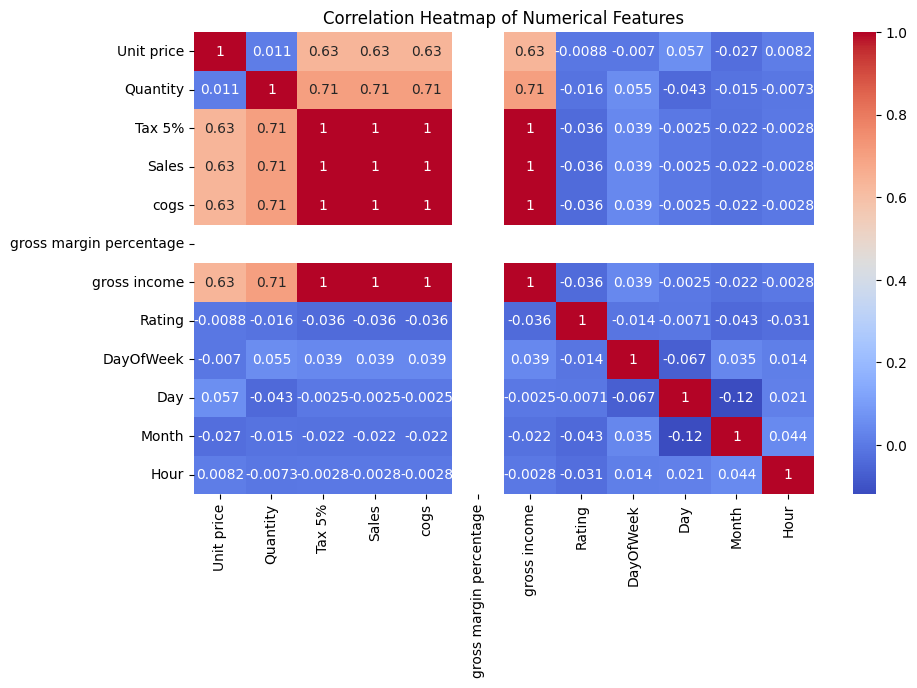

In [356]:

plt.figure(figsize=(10,6))
sns.heatmap(num_cols.corr(), annot=True, cmap='coolwarm')
plt.title("Correlation Heatmap of Numerical Features")
plt.show()

### Feature Engineering

In [357]:
# # Item Category
# # Extract first two letters from Item_ID to classify into Food/Drinks/Non-Consumable

# combined['Item_Category'] = combined['Item_ID'].str[:2].map({
#     'FD': 'Food',
#     'DR': 'Drinks',
#     'NC': 'Non-Consumable'
# })


# # Interaction Feature
# # IT refers to new features created by combining two or more existing features in a way that captures their relationship or interaction
# # Numerical Columns
# # 1. Relationship between item price and weight
# combined['MRP_Weight'] = combined['Item_MRP'] * combined['Item_W']

# #2.Item MRP × Sales:
# combined['MRP_Sales_interaction'] = combined['Item_MRP'] * combined['Sales']

# # 3. Item MRP × Outlet Year
# combined['MRP_OutletYear_interaction'] = combined['Item_MRP'] * combined['Outlet_Year']

# #4. Sales × MRP Weight

# combined['Sales_MRPWeight_interaction']= combined['Sales'] * combined['MRP_Weight']

# # Categorical Columns
# # -------------------------------------------------------------------
# #Research Polynomial Features

In [358]:
# # fitting on train and transforming test separately may be okay for label encoding,
# # but doing all encodings on `combined` ensures absolute consistency for all categorical transforms.
# # Label-encode 'Outlet_ID' on combined so encoding is consistent across train/test
# from sklearn.preprocessing import LabelEncoder
# le = LabelEncoder()
# combined['Outlet_ID'] = le.fit_transform(combined['Outlet_ID'].astype(str))

# # Now that we've applied all encodings on `combined`, re-split into train_cleaned and test_cleaned
# # This ensures the encoded columns appear exactly the same in both sets.
# train_cleaned = combined[combined['source'] == 'train'].copy()
# test_cleaned = combined[combined['source'] == 'test'].copy()

# # If 'Sales_transformed_capped' was previously created for modeling, ensure it exists for train
# # If not present yet, create it by copying 'Sales' (this was your previous simple approach)
# if 'Sales_transformed_capped' not in train_cleaned.columns:
#     train_cleaned['Sales_transformed_capped'] = train_cleaned['Sales']

# # Drop the helper 'source' column now that we've re-split (keeps dataframes clean)
# train_cleaned.drop(columns=['source'], inplace=True)
# test_cleaned.drop(columns=['source'], inplace=True)


In [359]:
# # Create output folder, fit the chosen model on the full training data, and save model + preprocessor
# import os
# from sklearn.ensemble import GradientBoostingRegressor

# os.makedirs('ML_Model', exist_ok=True)

# # Instantiate the model
# best_model = GradientBoostingRegressor(random_state=42)

# # Fit on the full preprocessed training data
# # X_train_processed and y_train are expected to be in the notebook kernel
# best_model.fit(X_train_processed, y_train)

# # Save the fitted model
# import joblib
# joblib.dump(best_model, os.path.join('ML_Model', 'GradientBoostingRegressor.pkl'))
# print("Saved fitted GradientBoostingRegressor to ML_Model/GradientBoostingRegressor.pkl")

# # Also save the preprocessing pipeline so you can transform new data the same way
# try:
#     joblib.dump(preprocessor, os.path.join('ML_Model', 'preprocessor.pkl'))
#     print("Saved preprocessor to ML_Model/preprocessor.pkl")
# except Exception as e:
#     print("Warning: could not save preprocessor:", e)


In [360]:
# # TARGET & DATA DIAGNOSTICS
# print("=== Target (Sales) Diagnostics ===")
# print("Target statistics:")
# print(y_train.describe())
# print("\nTarget distribution skewness:", y_train.skew())
# print("\nFeature count:", X_train_processed.shape[1])
# print("Train samples:", X_train_processed.shape[0])
# print("Target variance:", y_train.var())
# print("Target std dev:", y_train.std())



In [361]:
# # Check if target has unusual properties
# print("\nSales value counts (bottom 10):")
# print(y_train.value_counts().tail(10))
# print("\nUnique sales values:", y_train.nunique())

In [362]:
# # Feature importance via correlation matrix
# print("\n=== Feature Summary ===")
# print("Features that will be used:")
# for i, feat in enumerate(numeric_features):
#     print(f"  {i+1}. {feat}")

### Encoding


In [363]:
num_cols.head()

,Unit price,Quantity,Tax 5%,Sales,cogs,gross margin percentage,gross income,Rating,DayOfWeek,Day,Month,Hour
0,74.69,7,26.1415,548.9715,522.83,4.761905,26.1415,9.1,5,5,1,13
1,15.28,5,3.8200,80.2200,76.40,4.761905,3.8200,9.6,4,8,3,10
2,46.33,7,16.2155,340.5255,324.31,4.761905,16.2155,7.4,6,3,3,13
3,58.22,8,23.2880,489.0480,465.76,4.761905,23.2880,8.4,6,27,1,20
4,86.31,7,30.2085,634.3785,604.17,4.761905,30.2085,5.3,4,8,2,10


In [364]:
# Encoding numerical columns with standard scalar
num_cols = num_cols.columns.tolist()
scaler = StandardScaler()
df_scaled = df.copy()  # keep original dataset
df_scaled[num_cols] = scaler.fit_transform(df[num_cols])

In [365]:
# cat_cols.drop(columns=["Invoice ID"],inplace=True)

In [366]:
cat_cols.head()

,Branch,City,Customer type,Gender,Product line,Payment,TimeOfDay
0,Alex,Yangon,Member,Female,Health and beauty,Ewallet,Afternoon
1,Giza,Naypyitaw,Normal,Female,Electronic accessories,Cash,Morning
2,Alex,Yangon,Normal,Female,Home and lifestyle,Credit card,Afternoon
3,Alex,Yangon,Member,Female,Health and beauty,Ewallet,Evening
4,Alex,Yangon,Member,Female,Sports and travel,Ewallet,Morning


In [367]:
# Encoding categorical columns with One Hpt Encoding
#Note Customer Type might need to be encoded in another way
cat_cols = cat_cols.columns.tolist()
df_encoded = pd.get_dummies(df, columns=cat_cols, drop_first=False)


In [368]:
# df_encoded.drop(columns=["Invoice ID"],inplace=True)

In [369]:
df_encoded.head()

,Unit price,Quantity,Tax 5%,Sales,cogs,gross margin percentage,gross income,Rating,DayOfWeek,Day,Month,Hour,Branch_Alex,Branch_Cairo,Branch_Giza,City_Mandalay,City_Naypyitaw,City_Yangon,Customer type_Member,Customer type_Normal,Gender_Female,Gender_Male,Product line_Electronic accessories,Product line_Fashion accessories,Product line_Food and beverages,Product line_Health and beauty,Product line_Home and lifestyle,Product line_Sports and travel,Payment_Cash,Payment_Credit card,Payment_Ewallet,TimeOfDay_Afternoon,TimeOfDay_Evening,TimeOfDay_Morning
0,74.69,7,26.1415,548.9715,522.83,4.761905,26.1415,9.1,5,5,1,13,True,False,False,False,False,True,True,False,True,False,False,False,False,True,False,False,False,False,True,True,False,False
1,15.28,5,3.8200,80.2200,76.40,4.761905,3.8200,9.6,4,8,3,10,False,False,True,False,True,False,False,True,True,False,True,False,False,False,False,False,True,False,False,False,False,True
2,46.33,7,16.2155,340.5255,324.31,4.761905,16.2155,7.4,6,3,3,13,True,False,False,False,False,True,False,True,True,False,False,False,False,False,True,False,False,True,False,True,False,False
3,58.22,8,23.2880,489.0480,465.76,4.761905,23.2880,8.4,6,27,1,20,True,False,False,False,False,True,True,False,True,False,False,False,False,True,False,False,False,False,True,False,True,False
4,86.31,7,30.2085,634.3785,604.17,4.761905,30.2085,5.3,4,8,2,10,True,False,False,False,False,True,True,False,True,False,False,False,False,False,False,True,False,False,True,False,False,True


In [370]:
# These  columns might be causing data leakage['Tax 5%', 'cogs', 'gross margin percentage', 'gross income']
df_encoded.drop(columns=['Tax 5%', 'cogs', 'gross margin percentage', 'gross income'],inplace=True)


### Initial Model Training

In [371]:
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

X = df_encoded.drop(columns=["Sales"])  # features
y = df_encoded["Sales"]                 # target


X_train, X_test, y_train, y_test = train_test_split(
    X, y, 
    test_size=0.2,     # 20% test, 80% train
    random_state=42,   # reproducible
)


models =  {
    "Linear Regression": LinearRegression(),
    "Ridge Regression": Ridge(alpha=1.0),
    "Lasso Regression": Lasso(alpha=0.1),
    "Random Forest": RandomForestRegressor(n_estimators=100, random_state=42),
    "Gradient Boosting": GradientBoostingRegressor(n_estimators=100, random_state=42),
    "SVR": SVR(kernel="rbf")
}


for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    
    print(f"=== {name} ===")
    print("R² Score:", r2_score(y_test, y_pred))
    print("Mean Squared Error:", mean_squared_error(y_test, y_pred))
    print("Mean Absolute Error:", mean_absolute_error(y_test, y_pred))
    print("\n")



=== Linear Regression ===
R² Score: 0.9014555937489659
Mean Squared Error: 6411.201150994641
Mean Absolute Error: 59.56695551535304


=== Ridge Regression ===
R² Score: 0.9014888792336445
Mean Squared Error: 6409.035630435924
Mean Absolute Error: 59.55506536453335


=== Lasso Regression ===
R² Score: 0.9019693378153879
Mean Squared Error: 6377.777472520483
Mean Absolute Error: 59.37661204567196


=== Random Forest ===
R² Score: 0.9980110984526516
Mean Squared Error: 129.39595837730766
Mean Absolute Error: 7.619031524999986


=== Gradient Boosting ===
R² Score: 0.9982513133253734
Mean Squared Error: 113.76781745008448
Mean Absolute Error: 7.895301739093293


=== SVR ===
R² Score: 0.17128933532765522
Mean Squared Error: 53915.09238641455
Mean Absolute Error: 174.02713004994845


